In [1]:
import os
import cv2
import time
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import matplotlib.pyplot as plt
from torch.autograd import Variable
from livelossplot import PlotLosses
from torchsummary import summary
from sklearn import preprocessing

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cuda


In [2]:
from cnn.Model import EESPNet_Reg

In [3]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

In [4]:
class PredModel(torch.nn.Module):
    def __init__(self, pred_dim):
        super(PredModel, self).__init__()
        
        # Prediciton layers
        self.pred_layers = []
        for i in range(len(pred_dim) - 1):
            pred_layer = nn.Sequential(
                nn.Linear(pred_dim[i][0], pred_dim[i + 1][0]),
                nn.LeakyReLU(),
                nn.Dropout(pred_dim[i + 1][1])
            )
            self.pred_layers.append(pred_layer)
        self.pred_layers.append(nn.Linear(pred_dim[-1][0], 4)) #Trocar aqui
        self.pred_layers = nn.Sequential(*self.pred_layers)


    def forward(self, feats):
        pred = self.pred_layers(feats)
        return(pred)

In [5]:

def calc_pad(shp):
    shpd = np.array([400, 200]) - shp
    shpl = shpd - np.int0(shpd/2)
    shpr = shpd - shpl
    shpp = ((0,0), (shpl[0], shpr[0]), (shpl[1], shpr[1]))
    return(shpp)

class MyDataset(torch.utils.data.Dataset):
    '''
    Class to load the dataset
    '''
    def __init__(self, im_dir, imList, labels):
        '''
        :param imList: image list (Note that these lists have been processed and pickled using the loadData.py)
        :param labelList: label list (Note that these lists have been processed and pickled using the loadData.py)
        '''          
        data = []
        for idx in range(len(imList)):
            image_names = imList[idx]
            label = labels[idx]
            img_list = []
            for image_name in image_names:
                im_name = os.path.join(im_dir, image_name)
                image = cv2.imread(im_name)
                image = cv2.resize(image, (np.min([200, int(image.shape[1]/4)]), np.min([400, int(image.shape[0]/4)])))
                image = np.moveaxis(image, 2, 0)
                image = np.pad(image, calc_pad(np.array(image.shape[1:])), 'constant', constant_values=(255))
                image = image.astype('float')
                image -= 128
                image /= 35
                img_list.append(torch.from_numpy(image))

            label = torch.from_numpy(label)
            data.append([img_list, label])
        self.data = data

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        '''

        :param idx: Index of the image file
        :return: returns the image and corresponding label file.
        '''
        img_list, label = self.data[idx]
        images = [Variable(i).to(device, dtype=torch.float) for i in img_list]
        label = Variable(label).to(device, dtype=torch.float)
        
        return (images, label)

In [6]:
# Diretório das imagens
data_dir  = '../../Datasets/Eucalyptus3/Jetson/'
im_dir  = '../../Datasets/Eucalyptus3/Jetson/Jetson_Imgs2/'
# Lê o diâmetro das mudas no arquivo csv
imfs = pd.read_csv(os.path.join(data_dir, 'Dataset_Jetson_2.csv'), sep = ',', decimal= '.', header = 0)

#y_target = imfs.n_folhas.values.astype('float')
#y_target -= 10
#y_target /= y_target.std()

# Carrega os dados
y_folhas = imfs.n_folhas.values.astype('float')
y_brotos = imfs.n_brotos.values.astype('float')
y_folhas_brotos = imfs.n_folha_broto.values.astype('float')
y_folhas_apicais = imfs.folhas_apicais.values.astype('float')
y_target = np.stack((y_folhas, y_brotos,y_folhas_brotos,y_folhas_apicais), axis=-1)

# Faz a normalização dos dados
#y_target = preprocessing.normalize(y_target, norm='l2')
#maxx = np.max(y_target)
minimo = y_target.min(0)
maximo = y_target.max(0)
y_target = (y_target-minimo)/(maximo-minimo)
# Cria os dataframes e cria os conjuntos de treinamento e validação
im_train = np.arange(len(imfs))
im_val = np.random.choice(im_train, 10, replace=False)
im_train = np.setdiff1d(im_train,im_val)

In [7]:
train_dataset =  MyDataset(im_dir, imfs.values[im_train,5:], y_target[im_train])

val_dataset =  MyDataset(im_dir, imfs.values[im_val,5:], y_target[im_val])

In [8]:
print(len(train_dataset), len(val_dataset))

54 10


In [9]:
# Carrega o dataset de treinamento
train_loader = torch.utils.data.DataLoader(train_dataset,
                          batch_size=10,
                          shuffle=True,
                          num_workers=0
                         )

# Carrega o dataset de validação
val_loader = torch.utils.data.DataLoader(val_dataset,
                          batch_size=10,
                          shuffle=True,
                          num_workers=0
                         )

In [89]:
fct_dim = [160, 32,  4]
fct_dropout = 0.1
fct_dim = [[x, fct_dropout] for x in fct_dim]

# Atribui o modelo
modelp = PredModel(fct_dim)
modelp = modelp.to(device)
# modelp.load_state_dict(torch.load('../data/PredModel_tmp.pth',map_location=device), strict=False)

summary(modelp, input_size= (160,))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                   [-1, 32]           5,152
         LeakyReLU-2                   [-1, 32]               0
            Linear-3                    [-1, 4]             132
         LeakyReLU-4                    [-1, 4]               0
            Linear-5                    [-1, 4]              20
Total params: 5,304
Trainable params: 5,304
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.02
Estimated Total Size (MB): 0.02
----------------------------------------------------------------


In [90]:
# Atribui o modelo
model = EESPNet_Reg(n_out = 4, s = 0.5)
model = model.to(device)
# model.load_state_dict(torch.load('../data/FeatModel_tmp.pth',map_location=device), strict=False)
summary(model, input_size=(3, 400, 200))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 8, 200, 100]             216
       BatchNorm2d-2          [-1, 8, 200, 100]              16
             PReLU-3          [-1, 8, 200, 100]               8
               CBR-4          [-1, 8, 200, 100]               0
         AvgPool2d-5           [-1, 8, 100, 50]               0
            Conv2d-6          [-1, 4, 200, 100]              16
       BatchNorm2d-7          [-1, 4, 200, 100]               8
             PReLU-8          [-1, 4, 200, 100]               4
               CBR-9          [-1, 4, 200, 100]               0
           Conv2d-10           [-1, 4, 100, 50]              36
         CDilated-11           [-1, 4, 100, 50]               0
           Conv2d-12           [-1, 4, 100, 50]              36
         CDilated-13           [-1, 4, 100, 50]               0
      BatchNorm2d-14           [-1, 8, 

In [91]:
learning_rate = 1e-3
criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(list(model.parameters()) + list(modelp.parameters()), learning_rate)


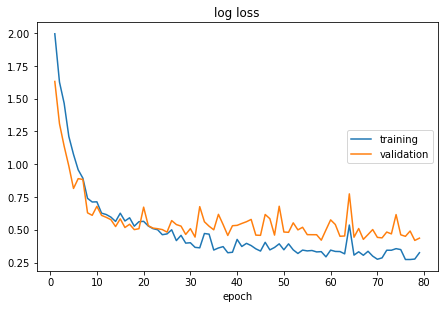

log loss:
training   (min:    0.273, max:    1.995, cur:    0.325)
validation (min:    0.419, max:    1.631, cur:    0.436)
[1:78] loss: 0.325 time:2.89


KeyboardInterrupt: 

In [92]:
min_loss = 1e9
bad_epochs = 0

liveloss = PlotLosses()
for epoch in range(100):
    bad_epochs += 1
    start_time = time.time()
    epoch_loss = []
    val_loss = []
    
    model.train()
    for (imgs, labels) in train_loader:
        
        #-------------------------------------------
        # Obtem o output
        loss = 0
        feats = []
        for img in imgs:
            pred, feat = model(img)
            loss += criterion(pred, labels)
            feats.append(feat)
        r = torch.randperm(len(feats))
        predf = modelp(torch.cat([feats[i] for i in r], 1))
        loss += criterion(predf, labels)
        
        # Limpa os gradientes
        optimizer.zero_grad()

        # Obtem os gradientes
        loss.backward()

        # Atualiza os parâmetros
        optimizer.step()

        epoch_loss.append(loss.data.item())
    
    model.eval()
    with torch.no_grad():
        for (imgs, labels) in val_loader:
            loss = 0
            feats = []
            for img in imgs:
                pred, feat = model(img)
                loss += criterion(pred, labels)
                feats.append(feat)
            predf = modelp(torch.cat(feats, 1))
            loss += criterion(predf, labels)
            val_loss.append(loss.data.item())
        
    epoch_loss = np.array(epoch_loss).mean()
    val_loss = np.array(val_loss).mean()
    time_taken = time.time() - start_time
    
    #save the model
    model_file_name = '../data/FeatModel_tmp.pth'
    modelp_file_name = '../data/PredModel_tmp.pth'
    if val_loss < min_loss:
        torch.save(model.state_dict(), model_file_name)
        torch.save(modelp.state_dict(), modelp_file_name)
        min_loss = val_loss
        bad_epochs = 0
    if bad_epochs > 100:
        break

    liveloss.update({
        'log loss': epoch_loss,
        'val_log loss': val_loss
    })
    liveloss.draw()
    print('[%d:%d] loss: %.3f time:%.2f' % (bad_epochs, epoch, epoch_loss, time_taken))
    

In [93]:
# Carrega os pesos de um modelo salvo
model.load_state_dict(torch.load(model_file_name,map_location=device))
modelp.load_state_dict(torch.load(modelp_file_name,map_location=device))

print('Modelo OK')

Modelo OK


In [94]:
start_time = time.time()

model.eval()

obs = []
preds = []

obsf = []
predsf = []
for i, (imgs, labels) in enumerate(val_loader):
    feats = []
    for img in imgs:
        with torch.no_grad():
            pred, feat = model(img)
            feats.append(feat)
        preds.append(pred.cpu().data.numpy())
        obs.append(labels.cpu().data.numpy())

    predf = modelp(torch.cat(feats, 1))
    predsf.append(pred.cpu().data.numpy())
    obsf.append(labels.cpu().data.numpy())

y_obs = np.concatenate(obs)
y_pred = np.concatenate(preds)
y_obs = (y_obs+minimo)*(maximo-minimo)
y_pred = (y_pred+minimo)*(maximo-minimo)

y_obsf = np.concatenate(obsf)
y_predf = np.concatenate(predsf)
y_obsf = (y_obsf+minimo)*(maximo-minimo)
y_predf = (y_predf+minimo)*(maximo-minimo)


time_taken = time.time() - start_time
print('time:%.2f' % (time_taken))


time:0.20


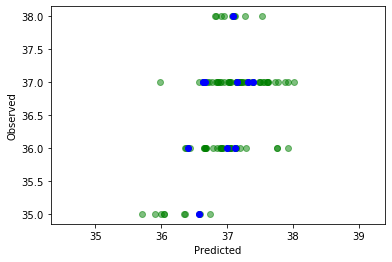

In [99]:
idx = 0
ax = plt.axes()
ax.set_aspect('equal', 'datalim')
plt.plot(y_pred[:,idx], y_obs[:,idx], 'go', alpha = .5)
plt.plot(y_predf[:,idx], y_obsf[:,idx], 'bo', alpha = 1.)
plt.xlabel('Predicted')
plt.ylabel('Observed')
plt.show()


In [100]:
np.round(np.corrcoef(y_pred, y_obs, rowvar=False),2)

array([[ 1.  , -0.5 , -0.52,  0.73,  0.49, -0.2 , -0.23,  0.39],
       [-0.5 ,  1.  ,  1.  , -0.04, -0.24,  0.52,  0.6 , -0.  ],
       [-0.52,  1.  ,  1.  , -0.08, -0.25,  0.52,  0.59, -0.01],
       [ 0.73, -0.04, -0.08,  1.  ,  0.22, -0.03, -0.02,  0.39],
       [ 0.49, -0.24, -0.25,  0.22,  1.  , -0.35, -0.24,  0.22],
       [-0.2 ,  0.52,  0.52, -0.03, -0.35,  1.  ,  0.94,  0.04],
       [-0.23,  0.6 ,  0.59, -0.02, -0.24,  0.94,  1.  ,  0.16],
       [ 0.39, -0.  , -0.01,  0.39,  0.22,  0.04,  0.16,  1.  ]])

In [101]:
print(y_obsf)

[[38.00000012  0.          0.          1.00000003]
 [36.00000001  5.          7.          2.00000006]
 [36.00000001  1.00000001  1.00000004  2.00000006]
 [37.00000003  0.          0.          2.00000006]
 [37.00000003  0.          0.          2.00000006]
 [35.          0.          0.          1.00000003]
 [37.00000003  0.          0.          2.00000006]
 [37.00000003  0.          0.          2.00000006]
 [37.00000003  2.00000003  5.00000012  2.00000006]
 [36.00000001  3.00000012  3.00000003  1.00000003]]


In [102]:
print(y_predf)

[[ 3.70817886e+01  2.32920423e-01  1.57031989e-01  1.72750676e+00]
 [ 3.70010634e+01  3.60856839e-01  4.27197538e-01  1.52044630e+00]
 [ 3.71157791e+01  1.03716202e+00  1.85232607e+00  1.77419132e+00]
 [ 3.71561711e+01  3.58695872e-01  4.79435101e-01  1.67154819e+00]
 [ 3.73213322e+01  1.43328030e-01  2.96446700e-02  1.41454321e+00]
 [ 3.65797788e+01  1.42433107e+00  2.71285331e+00  1.81518584e+00]
 [ 3.66316167e+01  1.45389006e+00  2.89316911e+00  1.26833868e+00]
 [ 3.73859283e+01 -5.39817894e-02 -4.61500101e-01  1.88838083e+00]
 [ 3.66572452e+01  3.03147554e+00  6.21366858e+00  1.92563528e+00]
 [ 3.64065614e+01  9.95196626e-01  1.83370873e+00  1.13165510e+00]]
